# **General Elections Classifier using Feed Forward Neural Networks**
---
### Pavlos Dais


# **Prerequisites**

In [1]:
!pip install spacy
!python -m spacy download el_core_news_sm
!pip install optuna
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.el.300.vec.gz
!gzip -d cc.el.300.vec.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 43.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_sm')
--2023-12-31 11:37:21--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.el.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.38, 13.35.7.82, 13.35.7.50, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1256281783 (1.2G) [binary/octet-stream]
Saving to: ‘cc.el.300.vec.gz’

cc.el.300.vec.gz    100%[===================>]   1.17G   142MB/s    in 8.9s    

2023-12-31 11:37:31 (135 MB/s) - ‘cc.el.300.vec.gz’ saved [1256281783/1256281783]



In [2]:
import pandas as pd
import numpy as np

# neural nets library
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os

# set random seed to get the same results
np.random.seed(0)
torch.manual_seed(0)
import random
random.seed(0)

torch.backends.cudnn.deterministic = True

# used for metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import auc, roc_curve

# create word embeddings
from gensim.models import Word2Vec

# optimization
import torch.optim as optim

from nltk import FreqDist
from sklearn.preprocessing import label_binarize
from matplotlib import pyplot as plt
import re
import optuna
from gensim.models import KeyedVectors

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import label_binarize
from itertools import cycle

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

nltk.download("omw")
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('greek'))

# avoid error at data cleaning
pd.options.mode.chained_assignment = None

import spacy
from spacy.lang.el.examples import sentences 

from collections import Counter
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

nlp = spacy.load("el_core_news_sm")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw to /usr/share/nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Useful Code for Analysis**

In [3]:
def show_most_common(data_a, common_words_num):
    # combine all text into a single string
    text = ' '.join(data_a['Text'])

    # generate word frequencies
    word_freq = pd.Series(text.lower().split()).value_counts()

    # plot the most common words
    word_freq.head(common_words_num).plot(kind='bar', rot=45)
    plt.title(f'Top {common_words_num} Most Common Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

# **Useful Code For Data Processing**

In [4]:
# emoji to text functionality
emoji_to_text = {
    "😃": "χαρα",
    "😢": "λυπη",
    "❤️": "καρδια",
    "👍": "συμφωνω",
    "👎": "διαφωνω"
}

# replace these vowels to remove accents
vowel_replacement = {
    'ά':'α',
    'έ':'ε',
    'ή':'η',
    'ί':'ι',
    'ό':'ο',
    'ύ':'υ',
    'ώ':'ω'
}

# my stop words (not included in the nltk library)
my_stop_words = ['ειναι', 'απο', 'οτι', 'μου', 'στις', 'μας', 'της', 'την', 'τον', 'τους', 'τη', 'το', 'στους', 'στα', 'σας', 'αυτο',
                'εχει', 'μια', 'ηταν', 'μια', 'σου', 'ενα', 'αυτος', 'εγω', 'σε', 'ενας', 'ειμαι', 'εχω', 'ο']

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

def translate_greek(text):
    translation_table = str.maketrans (
        'abcdefghijklmnopqrstuvwxyz',
        'αβκδεφγηιξκλμνοπθρστυϐωχυζ'
    )
    return text.translate(translation_table)

# preprocesses the tweet
def clean_tweet(tweet_str):
    
    # remove hashtags
    tweet_str = re.sub(r'#\w+', '', tweet_str)
    
    # remove @'s
    tweet_str = re.sub(r'@(\w+)', '', tweet_str)
    
    # remove urls
    tweet_str = re.sub(r'http[s]?://\S+', '', tweet_str)
    
    # remove numbers & special characters
    tweet_str = re.sub(r'[0-9]|\W', ' ', tweet_str)
    
    # remove excess tabs & white spaces
    tweet_str = re.sub(r'\s+', ' ', tweet_str).strip()
    
    # convert to lowercase for generalization
    tweet_str = tweet_str.upper()
    tweet_str = tweet_str.lower()
    
    # remove stop words
    tweet_str = ' '.join([word for word in tweet_str.split(' ') if word not in stop_words])
    
    # translate english text
    tweet_str = translate_greek(tweet_str)
    
    # replace some emojies with a corresponding text and remove the rest
    for old_vowel, new_vowel in emoji_to_text.items():
        tweet_str = tweet_str.replace(old_vowel, new_vowel)
    tweet_str = re.sub(r'[\U00010000-\U0010ffff]', '', tweet_str)
    
    # lemmatization
    tweet_str = lemmatize_text(tweet_str)
    
    # remove accents
    for old_vowel, new_vowel in vowel_replacement.items(): tweet_str = tweet_str.replace(old_vowel, new_vowel)
    
    # remove my stop words
    tweet_str = ' '.join([word for word in tweet_str.split(' ') if word not in my_stop_words])
    
    return tweet_str

def clean_data(text):
    return text.apply(lambda x: x.map(clean_tweet))

def print_data(text, rows):
    for i in range(rows):
        print(text.iloc[i])

def append_word(cell_value):
    return cell_value + new_word
        
def get_data(data):        
    # extract the important piece of info
    X = data[['Text']]
    Y = data[['Sentiment']]
    parties = data[['Party']]

    clean_X = clean_data(X)
    
    # add political party at the start of the tweet
    # helps to know which political party the tweet is being referred to in the training process
    for i in range(len(clean_X)):
        political_party = parties.loc[i, 'Party']
        clean_X.loc[i, 'Text'] = str(political_party) + ' ' + clean_X.loc[i, 'Text']
    
    return clean_X, Y

def get_test_data(data):
    # extract the important piece of info
    X = data[['Text']]
    parties = data[['Party']]

    clean_X = clean_data(X)
    
    # add political party at the start of the tweet
    for i in range(len(clean_X)):
        political_party = parties.loc[i, 'Party']
        clean_X.loc[i, 'Text'] = str(political_party) + ' ' + clean_X.loc[i, 'Text']
    
    return clean_X

# **Data Processing**

Before processing:


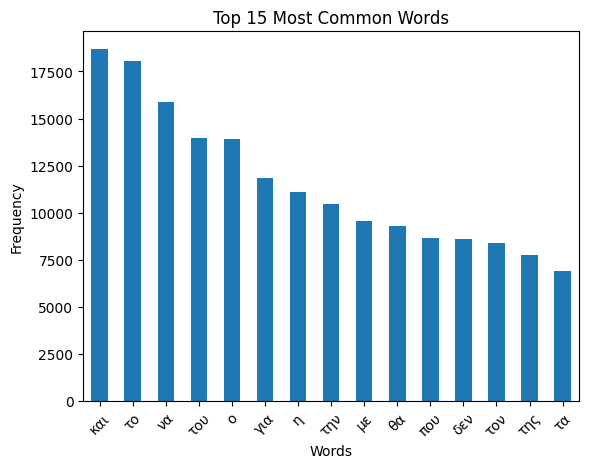

After processing:


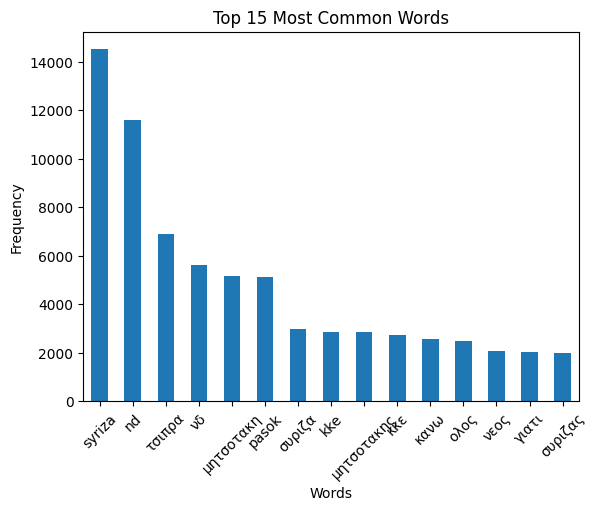

In [5]:
# read the dataframes
train_df = pd.read_csv("/kaggle/input/ys19-2023-assignment-2/train_set.csv")
test_df = pd.read_csv("/kaggle/input/ys19-2023-assignment-2/valid_set.csv")

# plot this many words
common_words_num = 15

print("Before processing:")
show_most_common(train_df, common_words_num)

# convert it
train_data = get_data(train_df)
test_data = get_data(test_df)

print("After processing:")
show_most_common(train_data[0], common_words_num)

In [6]:
# apply data pre processing
train_tweet_df = pd.DataFrame(train_df, columns=[train_df.columns[1]])
train_label_df = pd.DataFrame(train_df, columns=[train_df.columns[2]])

In [7]:
# initialize word vector
word_limit = 800000
word_vectors = KeyedVectors.load_word2vec_format('cc.el.300.vec', binary=False, limit=word_limit)

def conv_sentence(sentence, vector_size, word_vectors):
    mvector = np.zeros((1, vector_size)).astype(np.float64)
    words = sentence.split()

    for word in words:
        if word in word_vectors: mvector += word_vectors[word]
        else:                    mvector += np.zeros((1, vector_size)).astype(np.float64)

    return mvector / len(words)

def conv_sentences(sentences, vector_size, word_vectors):
    """
    This function converts a list of sentences into a tensor.
    Parameters:
    - sentences (list): The sentences we need to convert.
    - vector_size (int): The size of the vector.
    - word_vectors (word2vec): Word2vec vector.
    Returns: Nothing
    """
    
    x = np.zeros((len(sentences), vector_size)).astype(np.float64)
    i = 0
    for sentence in sentences:
        x[i] = conv_sentence(sentence, vector_size, word_vectors)
        i += 1
    return torch.from_numpy(x)

In [8]:
def calc_scores(y_true, y_pred, train_set):
    if train_set: print("Scores for training set:")
    else:         print("Scores for validation set:")
    
    # calculate scores
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall    = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    fscore    = f1_score(y_true, y_pred, average='weighted', zero_division=1)
    
    # show the scores
    print(f"Precision = {precision}")
    print(f"Recall    = {recall}")
    print(f"F1 score  = {fscore}\n")

def plot_results(epochs, train_scores, validation_scores, train_losses, validation_losses, y_true, y_pred, label):
    """
    This function plots the results of training (f1 score, loss learning, ROC curve).
    Parameters:
    - epochs (list): A list containing the epochs used during training.
    - train_scores (list): The train fscores during each epoch.
    - validation_scores (list): The validation scores during each epo
    - train_losses (list): The train losses during each epoch.
    - validation_losses (list): The validation losses during each epoch.
    - y_true (tensor): The actual labels.
    - y_pred (tensor): The predicited labels.
    - label (string): The title of the graph.
    Returns: Nothing
    """
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # plot f1 score
    ax1 = axes[0]
    ax1.plot(epochs, train_scores, label="Training Score")
    ax1.plot(epochs, validation_scores, label="Validation Score")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("FScore")
    ax1.legend()
    ax1.set_title("Fscore Learning Curve")
    
    # plot cross-entropy loss
    ax2 = axes[1]
    ax2.plot(epochs, train_losses, label="Training Loss")
    ax2.plot(epochs, validation_losses, label="Validation Loss")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Cross-Entropy Loss")
    ax2.legend()
    ax2.set_title("Loss Learning Curve")

    # plot ROC curves
    ax3 = axes[2]
    y_test = label_binarize(y_true, classes = [0, 1, 2])
    y_score = y_pred
    n_classes = 3

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plotting ROC curves side by side
    ax3.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["micro"]))

    for i in range(n_classes):
        ax3.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))
    
    ax3.plot([0, 1], [0, 1], 'k--')
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylabel('True Positive Rate')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_title('ROC all classes')
    ax3.legend(loc="lower right")
    
    fig.suptitle(label, fontsize=16)
    plt.tight_layout()
    plt.show()

In [9]:
def calculate_pred(model, x_data):
    model.eval()
    y_pred = model(x_data.float())
    proba = F.softmax(y_pred, dim=1)
    return y_pred, proba, proba.argmax(dim=1)

# the number of epochs allowed with no improvements
epoch_limit = 3
def train_model(train_data, val_data, model, loss_function, optimizer, batch_size, epochs_num):
    """
    This function trains a pytorch model on a specific number of epochs and batch size.
    Parameters:
    - train_data (tuple): The train data(x,y).
    - val_data (tuple): The validation data(x,y).
    - model: The model we will be training.
    - loss_function: The loss function we will be using during training.
    - optimizer: The optimizer we will be using during training.
    - batch_size: The number of batches our data we will be divided into.
    - epochs_num: The number of epochs that will take place.

    Returns:
    The fscore, loss values for both train and validation data. More specifically: 
    training scores (list), training losses (list), validation scores (list), validation losses (list), epochs (list), model
    """
    
    # extract train/ validation data
    # and create a dataloader to store it
    x_tr, y_tr   = train_data
    x_val, y_val = val_data
    dataset = torch.utils.data.TensorDataset(x_tr, y_tr)
    dload   = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # save fscore/loss values
    tr_scores  = list()
    tr_losses  = list()
    val_scores = list()
    val_losses = list()
    
    min_val_loss = np.Inf
    num_of_epochs = epochs_not_improved = 0

    for epoch in range(epochs_num):
        batch_scores = list()
        batch_losses = list()
    
        # current epoch train
        model.train()
        for x_batch, y_batch in dload:
            # reset old gradients and forward pass
            optimizer.zero_grad()
            y_pred = model(x_batch.float())
            
            # calculate scores
            loss = loss_function(y_pred, y_batch)
            batch_losses.append(loss.item())
            prob = F.softmax(y_pred, dim=1)
            y_pred = prob.argmax(dim=1)
            batch_scores.append(f1_score(y_batch, y_pred, average='weighted'))
            
            # backpropagate using this epoch's loss
            # then update the weights
            loss.backward()
            optimizer.step()
        
        y_val_pred, y_probs, y_val_label_pred = calculate_pred(model, x_val)
        
        # update scores
        loss = loss_function(y_val_pred, y_val).item()
        tr_losses.append(sum(batch_losses)/len(dload))
        tr_scores.append(sum(batch_scores)/len(dload))
        val_losses.append(loss)
        val_scores.append(f1_score(y_val, y_val_label_pred, average='weighted'))
        
        # early stopping: if no improvements (for <epoch_limit> times) have been made exit
        num_of_epochs += 1
        if (loss < min_val_loss):
            min_val_loss = loss
            epochs_not_improved = 0
        else:
            epochs_not_improved+=1
        if (epochs_not_improved == epoch_limit):
            print("Activated early stopping")
            break
    
    return tr_scores, tr_losses, val_scores, val_losses, [epoch for epoch in range(num_of_epochs)], model

# **Get sentences**

In [10]:
# get x values
x_train, y_train           = train_data
x_validation, y_validation = test_data
vector_size                = 300

train_sentences = [sentence for sentence in x_train['Text']]
val_sentences   = [sentence for sentence in x_validation['Text']]

x_train      = conv_sentences(train_sentences, vector_size, word_vectors)
x_validation = conv_sentences(val_sentences, vector_size, word_vectors)

In [11]:
# get y values
label_mapping = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}

y_train      = train_df[['Sentiment']]
y_validation = test_df[['Sentiment']]

y_train['Sentiment'] = y_train['Sentiment'].map(label_mapping)
y_train              = torch.tensor(y_train.values, dtype=torch.long)
y_train              = y_train.view(-1)

y_validation['Sentiment'] = y_validation['Sentiment'].map(label_mapping)
y_validation              = torch.tensor(y_validation.values, dtype=torch.long)
y_validation              = y_validation.view(-1)

# (finally) pack training, validation data together
train_d       = (x_train, y_train)
validation_d  = (x_validation, y_validation)

# **Training Process**
Here I experiment with different models (different number of layers & neurons per layer)

In [12]:
# default parameters
D_in  = x_train.shape[1]
D_out = 3
batch_size = 128

# *Model 1: Simple Neural Network*
Here I'm experimenting with a simple neural network that only uses 1 hidden layer

In [13]:
class NN_1(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(NN_1, self).__init__()
        
        self.input_layer  = nn.Linear(D_in, H1)
        self.output_layer = nn.Linear(H1, D_out)
    
    def forward(self, x):
        h1 = self.input_layer(x)              
        return self.output_layer(h1)

Scores for training set:
Precision = 0.37015524534072364
Recall    = 0.36683046683046683
F1 score  = 0.3437849660742581

Scores for validation set:
Precision = 0.3688649644502322
Recall    = 0.36601681957186544
F1 score  = 0.34267929528381813



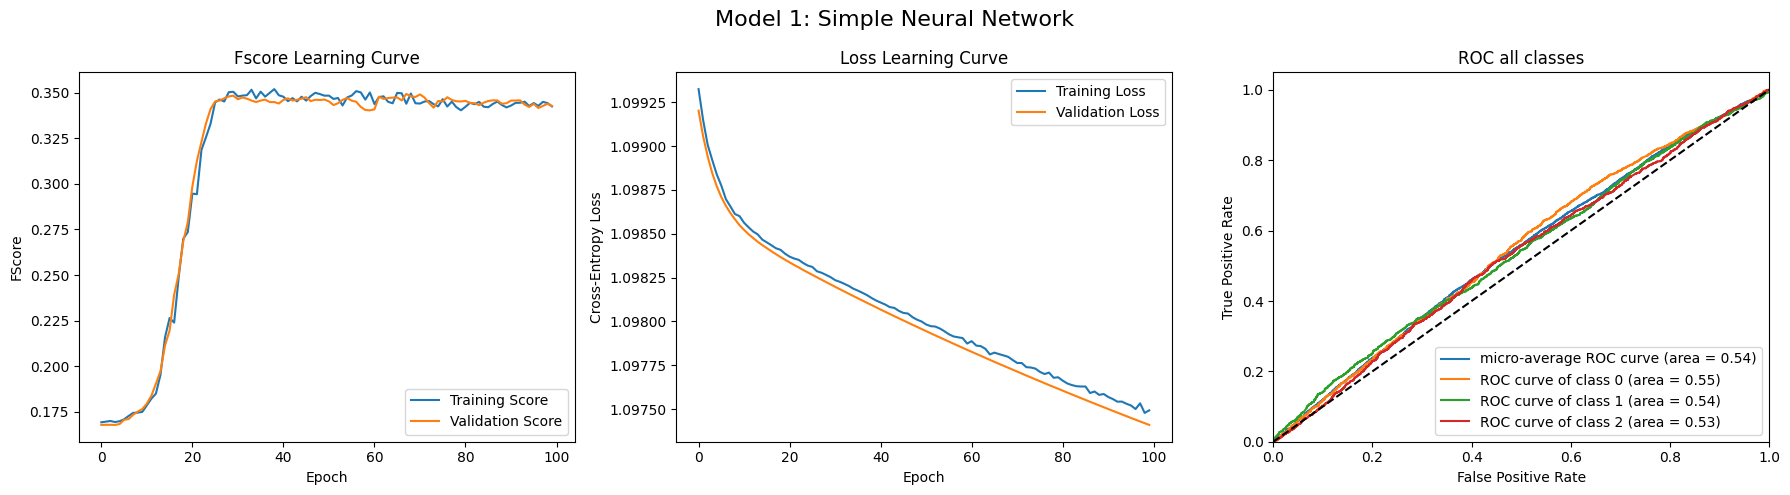

In [14]:
H1    = 64
model = NN_1(D_in, H1, D_out)

learning_rate = 1e-3
criterion     = nn.CrossEntropyLoss()
optimizer     = torch.optim.SGD(model.parameters(), lr=learning_rate)

tr_scores, tr_losses, val_scores, val_losses, epochs, model = train_model(train_d, validation_d, model, criterion, optimizer, batch_size, 100)

# show results
_, _, y_train_pred = calculate_pred(model, x_train)
calc_scores(y_train, y_train_pred, True)

_, y_probs, y_validation_pred = calculate_pred(model, x_validation)
calc_scores(y_validation, y_validation_pred, False)
    
plot_results(epochs, tr_scores, val_scores, tr_losses, val_losses, y_validation, y_probs.detach().numpy(),
             "Model 1: Simple Neural Network")

# *Model 2: 2 hidden layer using linear activation functions*
Here I'm experimenting with a neural network that uses 2 hidden layer with linear activation functions


In [15]:
class NN_2(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(NN_2, self).__init__()
        
        self.input_layer  = nn.Linear(D_in, H1)
        self.hidden_layer = nn.Linear(H1, H2)
        self.output_layer = nn.Linear(H2, D_out)
    
    def forward(self, x):
        h1 = self.input_layer(x)
        h2 = self.hidden_layer(h1)
        return self.output_layer(h2)

Scores for training set:
Precision = 0.36310182334710644
Recall    = 0.36295386295386295
F1 score  = 0.35177781568109534

Scores for validation set:
Precision = 0.36966150060654906
Recall    = 0.36850152905198774
F1 score  = 0.35840524715135735



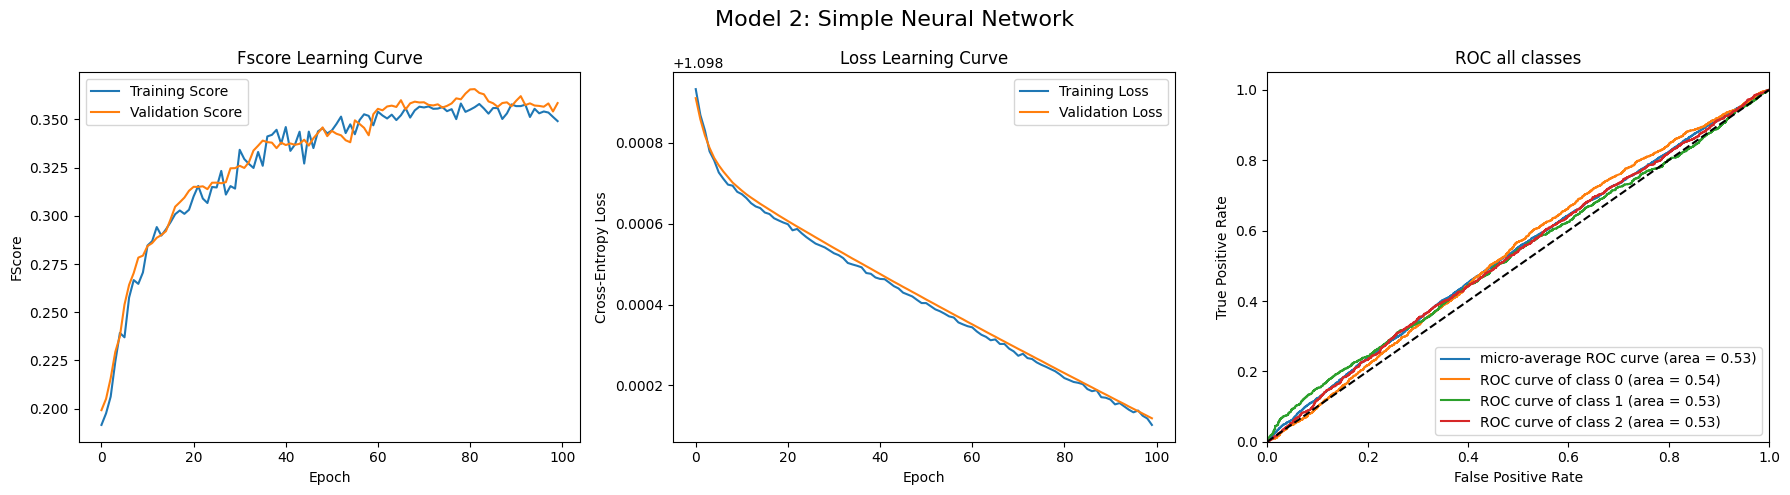

In [16]:
H1    = 128
H2    = 64
model = NN_2(D_in, H1, H2, D_out)

learning_rate = 1e-3
criterion     = nn.CrossEntropyLoss()
optimizer     = torch.optim.SGD(model.parameters(), lr=learning_rate)

tr_scores, tr_losses, val_scores, val_losses, epochs, model = train_model(train_d, validation_d, model, criterion, optimizer, batch_size, 100)

# show results
_, _, y_train_pred = calculate_pred(model, x_train)
calc_scores(y_train, y_train_pred, True)

_, y_probs, y_validation_pred = calculate_pred(model, x_validation)
calc_scores(y_validation, y_validation_pred, False)

plot_results(epochs, tr_scores, val_scores, tr_losses, val_losses, y_validation, y_probs.detach().numpy(),
             "Model 2: Simple Neural Network")

# *Model 3: 3 Hidden layers using ReLu activation functions*
Here I'm experimenting with a neural network that uses 3 hidden layer with ReLu activation functions

In [17]:
class NN_3(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out, dropout_rate=0.4):
        super(NN_3, self).__init__()

        self.input_layer   = nn.Linear(D_in, H1)
        self.activation1   = nn.ReLU()
        self.dropout1      = nn.Dropout(p=dropout_rate)
        self.hidden_layer1 = nn.Linear(H1, H2)
        self.activation2   = nn.ReLU()
        self.dropout2      = nn.Dropout(p=dropout_rate)
        self.hidden_layer2 = nn.Linear(H2, H3)
        self.activation3   = nn.ReLU()
        self.dropout3      = nn.Dropout(p=dropout_rate)
        self.output_layer  = nn.Linear(H3, D_out)

    def forward(self, x):
        h1 = self.activation1(self.input_layer(x))
        h1 = self.dropout1(h1)
        h2 = self.activation2(self.hidden_layer1(h1))
        h2 = self.dropout2(h2)
        h3 = self.activation3(self.hidden_layer2(h2))
        h3 = self.dropout3(h3)
        return self.output_layer(h3)

Activated early stopping
Scores for training set:
Precision = 0.46932664010154773
Recall    = 0.43611793611793614
F1 score  = 0.41123059191484185

Scores for validation set:
Precision = 0.4175924447030973
Recall    = 0.4023318042813456
F1 score  = 0.3762166260087757



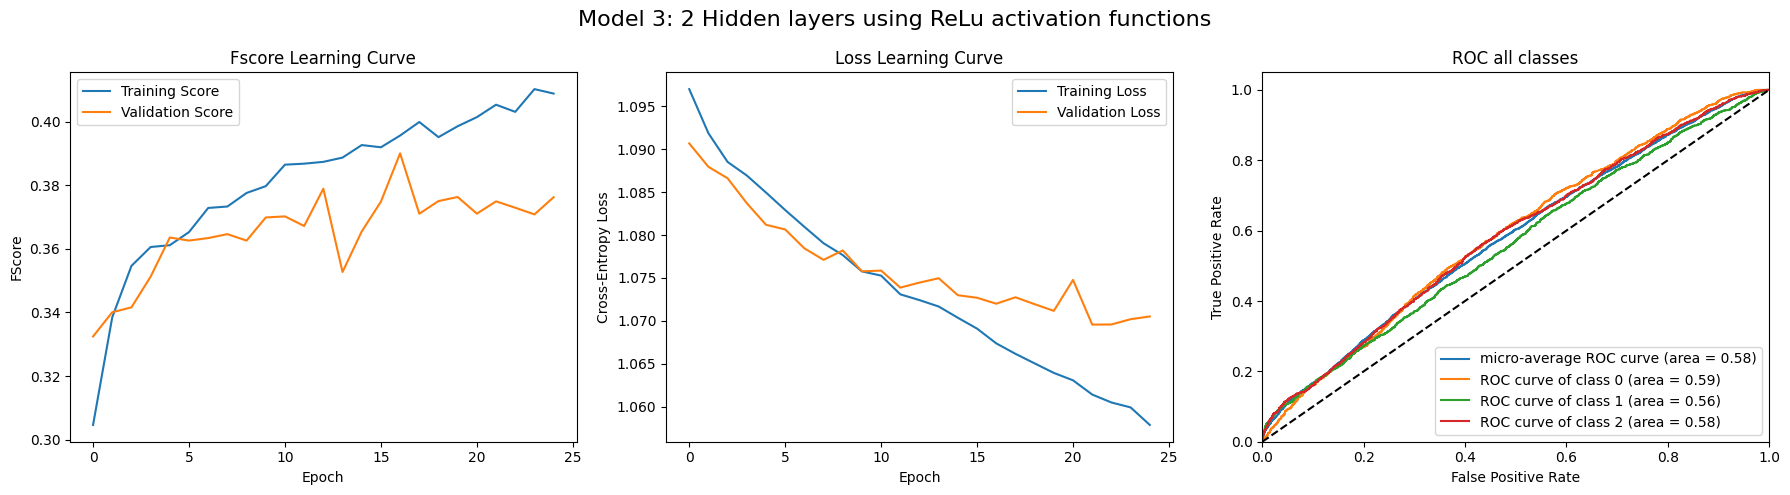

In [18]:
H1    = 128
H2    = 64
H3    = 32
model = NN_3(D_in, H1, H2, H3, D_out)

learning_rate = 1e-3
criterion     = nn.CrossEntropyLoss()
optimizer     = optim.Adam(model.parameters(), lr=learning_rate)

tr_scores, tr_losses, val_scores, val_losses, epochs, model = train_model(train_d, validation_d, model,
                                                                          criterion, optimizer, batch_size, 100)

# show results
_, _, y_train_pred = calculate_pred(model, x_train)
calc_scores(y_train, y_train_pred, True)

_, y_probs, y_validation_pred = calculate_pred(model, x_validation)
calc_scores(y_validation, y_validation_pred, False)

plot_results(epochs, tr_scores, val_scores, tr_losses, val_losses, y_validation, y_probs.detach().numpy(),
             "Model 3: 2 Hidden layers using ReLu activation functions")

# *Model 4: 4 Hidden layers using ReLu activation functions*
Here I'm experimenting with a neural network that uses 4 hidden layer with ReLu activation functions

In [19]:
class NN_4(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out, dropout_rate=0.4):
        super(NN_4, self).__init__()

        self.input_layer   = nn.Linear(D_in, H1)
        self.activation1   = nn.ReLU()
        self.dropout1      = nn.Dropout(p=dropout_rate)
        self.hidden_layer1 = nn.Linear(H1, H2)
        self.activation2   = nn.ReLU()
        self.dropout2      = nn.Dropout(p=dropout_rate)
        self.hidden_layer2 = nn.Linear(H2, H3)
        self.activation3   = nn.ReLU()
        self.dropout3      = nn.Dropout(p=dropout_rate)
        self.hidden_layer3 = nn.Linear(H3, H4)
        self.activation4   = nn.ReLU()
        self.dropout4      = nn.Dropout(p=dropout_rate)
        self.output_layer  = nn.Linear(H4, D_out)

    def forward(self, x):
        h1 = self.activation1(self.input_layer(x))
        h1 = self.dropout1(h1)
        h2 = self.activation2(self.hidden_layer1(h1))
        h2 = self.dropout2(h2)
        h3 = self.activation3(self.hidden_layer2(h2))
        h3 = self.dropout3(h3)
        h4 = self.activation4(self.hidden_layer3(h3))
        h4 = self.dropout4(h4)
        return self.output_layer(h4)

Activated early stopping
Scores for training set:
Precision = 0.7648417769817113
Recall    = 0.3352989352989353
F1 score  = 0.17087389803313235

Scores for validation set:
Precision = 0.777947932618683
Recall    = 0.3348623853211009
F1 score  = 0.16990215763472766



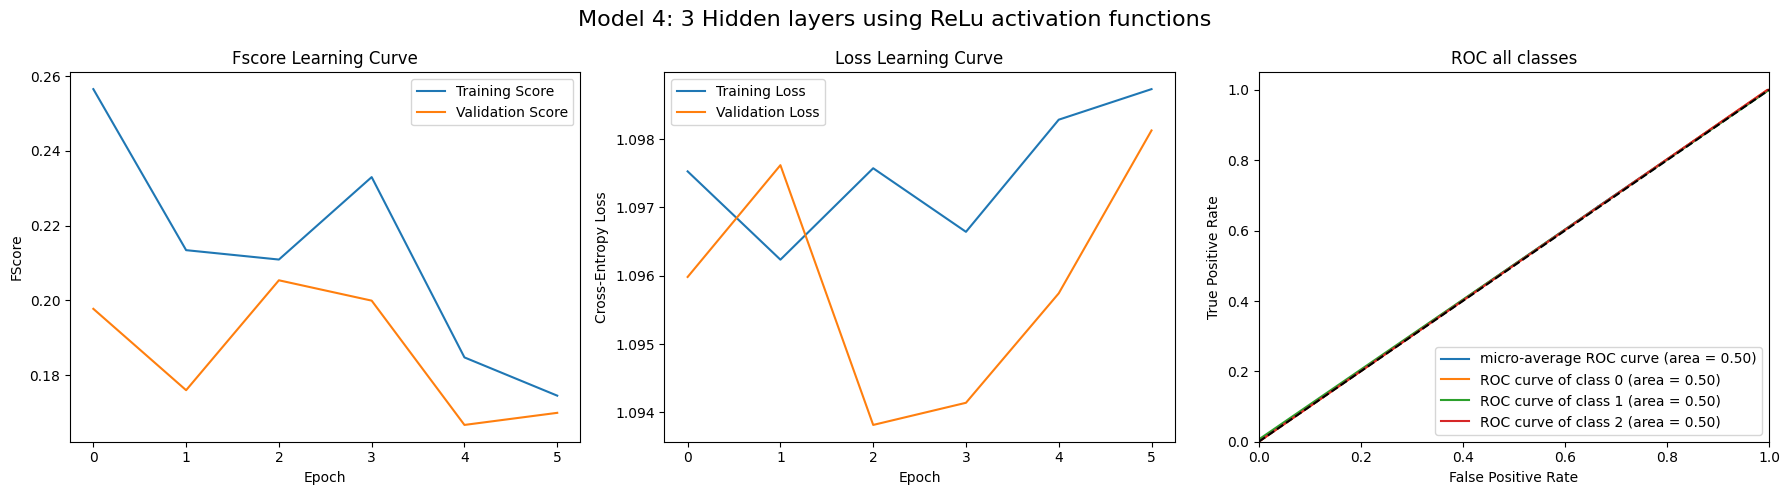

In [20]:
H1    = 256
H2    = 128
H3    = 64
H4    = 32
model = NN_4(D_in, H1, H2, H3, H4, D_out)

learning_rate = 1e-2
criterion     = nn.CrossEntropyLoss()
optimizer     = optim.Adam(model.parameters(), lr=learning_rate)

tr_scores, tr_losses, val_scores, val_losses, epochs, model = train_model(train_d, validation_d, model, criterion, optimizer, batch_size, 100)

# show results
_, _, y_train_pred = calculate_pred(model, x_train)
calc_scores(y_train, y_train_pred, True)

_, y_probs, y_validation_pred = calculate_pred(model, x_validation)
calc_scores(y_validation, y_validation_pred, False)

plot_results(epochs, tr_scores, val_scores, tr_losses, val_losses, y_validation, y_probs.detach().numpy(),
             "Model 4: 3 Hidden layers using ReLu activation functions")

# **Running optimization**
Finally, i'll be using the optuna framework for hyperparameter optimization.

In [21]:
# choose to optimize by searching for 3 or 4 layers and custom number of 
H1_r = H2_r = H3_r = H4_r = LR_r = None
layers_4 = False

def calculate_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

class Objective:
    def __init__(self, D_in, D_out):
        self.D_in = D_in
        self.D_out = D_out

    def __call__(self, trial):
        use_nn_4 = None
         
        if (layers_4):
            use_nn_4 = trial.suggest_categorical('use_nn_4', [True, False])

        if (use_nn_4):
            H1 = trial.suggest_int('H1', H1_r[0], H1_r[1])
            H2 = trial.suggest_int('H2', H2_r[0], H2_r[1])
            H3 = trial.suggest_int('H3', H3_r[0], H3_r[1])
            H4 = trial.suggest_int('H4', H4_r[0], H4_r[1])

            model = NN_4(self.D_in, H1, H2, H3, H4, self.D_out)
        else:
            H1 = trial.suggest_int('H1', H1_r[0], H1_r[1])
            H2 = trial.suggest_int('H2', H2_r[0], H2_r[1])
            H3 = trial.suggest_int('H3', H3_r[0], H3_r[1])

            model = NN_3(self.D_in, H1, H2, H3, self.D_out)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=trial.suggest_float('lr', LR_r[0], LR_r[1], log=True))
        epochs = trial.suggest_int('epochs', 5, 20)
        
        _, _, _, _, _, model = train_model(train_d, validation_d, model, criterion, optimizer, batch_size, epochs)
        
        _, _, y_train_pred = calculate_pred(model, x_train)
        return f1_score(y_train, y_train_pred, average='weighted', zero_division=1)

# **Optuna 1**

In [22]:
# search for hidden layers 3 and 4
# and a wide range of neurons
LR_r = [1e-5, 1e-1]
H1_r = [8, 512]
H2_r = [8, 512]
H3_r = [8, 512]
H4_r = [8, 512]
layers_4 = True

num_of_trials = 100
study = optuna.create_study(direction='maximize')
objective = Objective(D_in, D_out)
study.optimize(objective, n_trials=num_of_trials)

best_params = study.best_params
print("Best hyperparameters [optuna 1]:", best_params)

model = None
if (best_params['use_nn_4'] == True):
    model = NN_4(D_in, best_params['H1'], best_params['H2'], best_params['H3'], best_params['H4'], D_out)
else:
    model = NN_3(D_in, best_params['H1'], best_params['H2'], best_params['H3'], D_out)
    
learning_rate = best_params['lr']
criterion     = nn.CrossEntropyLoss()
optimizer     = optim.Adam(model.parameters(), lr=learning_rate)

tr_scores, tr_losses, val_scores, val_losses, epochs, model = train_model(train_d, validation_d, model, criterion,
                                                                          optimizer, batch_size, best_params['epochs'])

# show results
_, _, y_train_pred = calculate_pred(model, x_train)
calc_scores(y_train, y_train_pred, True)

_, y_probs, y_validation_pred = calculate_pred(model, x_validation)
calc_scores(y_validation, y_validation_pred, False)

plot_results(epochs, tr_scores, val_scores, tr_losses, val_losses, y_validation, y_probs.detach().numpy(),
             "Optuna 1")

# **Optuna 2**

In [23]:
# narrowing down the search space based on the previous results
# generally from running optimization multiple of time I noticed
# the model performs optimally (most of the times) using 3 hidden
# layers and neurons in this area:
# Hidden layer 1: [400, 512]
# Hidden layer 2: [450, 512]
# Hidden layer 3: [25, 150]

LR_r = [1e-5, 1e-1]
H1_r = [400, 512]
H2_r = [450, 512]
H3_r = [25, 150]
layers_4 = False

num_of_trials = 100
study = optuna.create_study(direction='maximize')
objective = Objective(D_in, D_out)
study.optimize(objective, n_trials=num_of_trials)

best_params = study.best_params
print("Best hyperparameters [optuna 2]:", best_params)

model = NN_3(D_in, best_params['H1'], best_params['H2'], best_params['H3'], D_out)
    
learning_rate = best_params['lr']
criterion     = nn.CrossEntropyLoss()
optimizer     = optim.Adam(model.parameters(), lr=learning_rate)

tr_scores, tr_losses, val_scores, val_losses, epochs, model = train_model(train_d, validation_d, model, criterion,
                                                                          optimizer, batch_size, best_params['epochs'])

# show results
_, _, y_train_pred = calculate_pred(model, x_train)
calc_scores(y_train, y_train_pred, True)

_, y_probs, y_validation_pred = calculate_pred(model, x_validation)
calc_scores(y_validation, y_validation_pred, False)

plot_results(epochs, tr_scores, val_scores, tr_losses, val_losses, y_validation, y_probs.detach().numpy(),
             "Optuna 2")

# **Optuna 3**

In [24]:
# narrowing down the search space based on the previous results
# generally from running optimization multiple of time I noticed
# the model performs optimally (most of the times) in these areas:
# Hidden layer 1: [420, 450]
# Hidden layer 2: [490, 512]
# Hidden layer 3: [70, 100]

LR_r = [1e-5, 1e-1]
H1_r = [420, 450]
H2_r = [490, 512]
H3_r = [70, 100]
layers_4 = False

num_of_trials = 100
study = optuna.create_study(direction='maximize')
objective = Objective(D_in, D_out)
study.optimize(objective, n_trials=num_of_trials)

best_params = study.best_params
print("Best hyperparameters [optuna 3]:", best_params)

model = NN_3(D_in, best_params['H1'], best_params['H2'], best_params['H3'], D_out)

learning_rate = best_params['lr']
criterion     = nn.CrossEntropyLoss()
optimizer     = optim.Adam(model.parameters(), lr=learning_rate)

tr_scores, tr_losses, val_scores, val_losses, epochs, model = train_model(train_d, validation_d, model, criterion,
                                                                          optimizer, batch_size, best_params['epochs'])

# show results
_, _, y_train_pred = calculate_pred(model, x_train)
calc_scores(y_train, y_train_pred, True)

_, y_probs, y_validation_pred = calculate_pred(model, x_validation)
calc_scores(y_validation, y_validation_pred, False)

plot_results(epochs, tr_scores, val_scores, tr_losses, val_losses, y_validation, y_probs.detach().numpy(),
             "Optuna 3")

# **Final Model**
This is my final model

Scores for training set:
Precision = 0.44702883408058813
Recall    = 0.44086814086814086
F1 score  = 0.43405225847343276

Scores for validation set:
Precision = 0.39991133855205024
Recall    = 0.3988914373088685
F1 score  = 0.39115763504565065



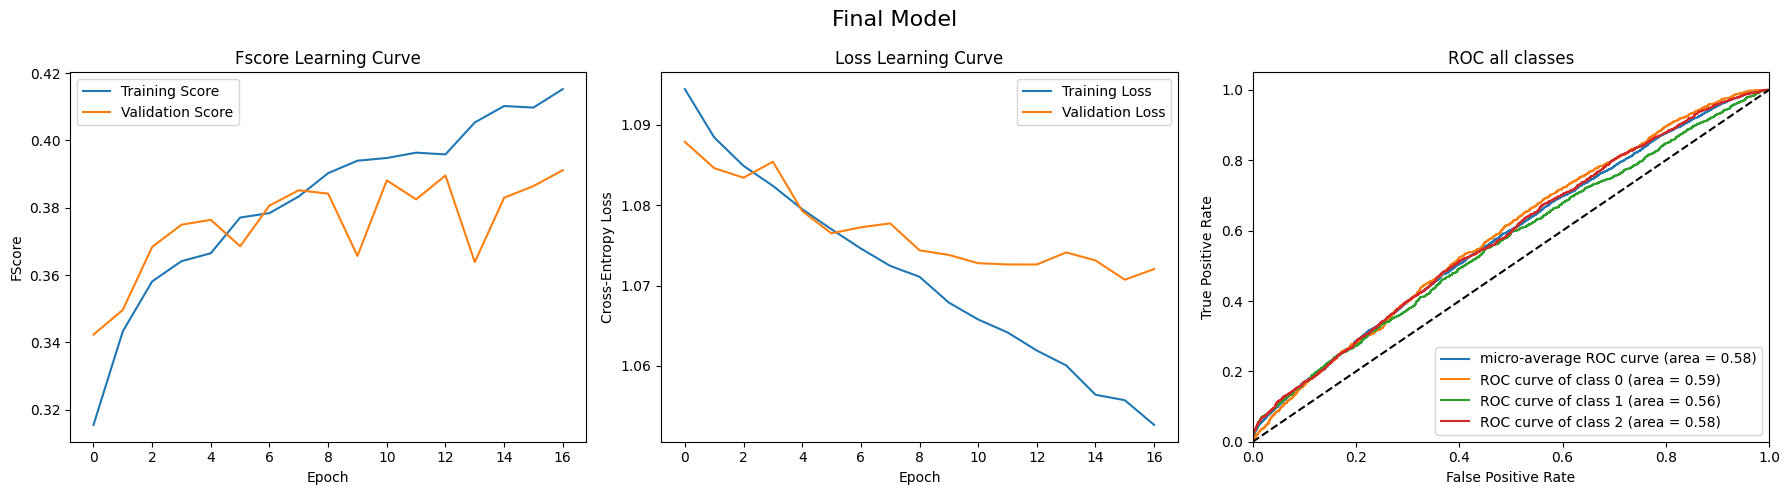

In [25]:
# after experimenting my final model is:
H1    = 427
H2    = 508
H3    = 91
final_model = NN_3(D_in, H1, H2, H3, D_out)

learning_rate = 0.0005347945157319929
criterion     = nn.CrossEntropyLoss()
optimizer     = optim.Adam(final_model.parameters(), lr=learning_rate)

tr_scores, tr_losses, val_scores, val_losses, epochs, final_model = train_model(train_d, validation_d, final_model,
                                                                          criterion, optimizer, batch_size, 17)

# show results
_, _, y_train_pred = calculate_pred(final_model, x_train)
calc_scores(y_train, y_train_pred, True)

_, y_probs, y_validation_pred = calculate_pred(final_model, x_validation)
calc_scores(y_validation, y_validation_pred, False)

plot_results(epochs, tr_scores, val_scores, tr_losses, val_losses, y_validation, y_probs.detach().numpy(),
             "Final Model")

## **Final Submission**

In [26]:
test_df = pd.read_csv("/kaggle/input/ys19-2023-assignment-2/test_set.csv") 
test_data = get_test_data(test_df)

In [27]:
test_sentences = [sentence for sentence in test_data['Text']]
x_test         = conv_sentences(test_sentences, vector_size, word_vectors)

_, _, y_train_pred = calculate_pred(final_model, x_test)

# convert into numpy
y_train_pred_numpy = y_train_pred.numpy()

label_mapping = {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}
vectorized_mapping = np.vectorize(lambda x: label_mapping[x])
mapped_array = vectorized_mapping(y_train_pred_numpy)

final_df = pd.DataFrame({'Id': test_df['New_ID'], 'Predicted': mapped_array})
final_df.to_csv('output_file.csv', index=False)